In [143]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from numpy.ma.extras import average
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

pio.templates.default = "plotly"
import warnings
warnings.filterwarnings("ignore")
# "plotly" (default)
# "plotly_white"
# "plotly_dark"
# "ggplot2"
# "seaborn"
# "simple_white"
# "none"

# LOAD

In [144]:
customer_demographics = pd.read_excel('data/Customer_Churn_Data_Large.xlsx', sheet_name='Customer_Demographics')
transaction_history = pd.read_excel('data/Customer_Churn_Data_Large.xlsx', sheet_name='Transaction_History')
cus_service = pd.read_excel('data/Customer_Churn_Data_Large.xlsx', sheet_name='Customer_Service')
online_activity = pd.read_excel('data/Customer_Churn_Data_Large.xlsx', sheet_name='Online_Activity')
churn_status = pd.read_excel('data/Customer_Churn_Data_Large.xlsx', sheet_name='Churn_Status')

In [145]:
for df in [customer_demographics, transaction_history, cus_service, online_activity, churn_status]:
    print(df.head())
    print('*****-----------------------------------------*******')

   CustomerID  Age Gender MaritalStatus IncomeLevel
0           1   62      M        Single         Low
1           2   65      M       Married         Low
2           3   18      M        Single         Low
3           4   21      M       Widowed         Low
4           5   21      M      Divorced      Medium
*****-----------------------------------------*******
   CustomerID  TransactionID TransactionDate  AmountSpent ProductCategory
0           1           7194      2022-03-27       416.50     Electronics
1           2           7250      2022-08-08        54.96        Clothing
2           2           9660      2022-07-25       197.50     Electronics
3           2           2998      2022-01-25       101.31       Furniture
4           2           1228      2022-07-24       397.37        Clothing
*****-----------------------------------------*******
   CustomerID  InteractionID InteractionDate InteractionType ResolutionStatus
0           1           6363      2022-03-31         Inqui

In [146]:
for df in [customer_demographics, transaction_history, cus_service, online_activity, churn_status]:
    print(df.info())
    print('*****-----------------------------------------*******')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     1000 non-null   int64 
 1   Age            1000 non-null   int64 
 2   Gender         1000 non-null   object
 3   MaritalStatus  1000 non-null   object
 4   IncomeLevel    1000 non-null   object
dtypes: int64(2), object(3)
memory usage: 39.2+ KB
None
*****-----------------------------------------*******
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5054 entries, 0 to 5053
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   CustomerID       5054 non-null   int64         
 1   TransactionID    5054 non-null   int64         
 2   TransactionDate  5054 non-null   datetime64[ns]
 3   AmountSpent      5054 non-null   float64       
 4   ProductCategory  5054 non-null   object        
dtypes:

# PREPROCESS

In [147]:
# Merge tables
merged_df = customer_demographics.merge(churn_status, on='CustomerID', how='left')
cus_churn = merged_df.merge(online_activity, how='left', on='CustomerID')
del merged_df

In [148]:
# merged_df = merged_df.merge(cus_service, how='left', on='CustomerID')
# merged_df = merged_df.merge(transaction_history, how='left', on='CustomerID')
# merged_df = transaction_history.merge(cus_service, on='CustomerID', how='left')
# merged_df = merged_df.merge(online_activity, how='left', on='CustomerID')
# merged_df = merged_df.merge(churn_status, how='left', on='CustomerID')
# cus_churn = merged_df.copy(deep=True)

In [149]:
# Check for duplicates
print(cus_churn.duplicated().sum())
# Check for Nans
print(cus_churn.isna().sum() / len(cus_churn) * 100)

0
CustomerID        0.0
Age               0.0
Gender            0.0
MaritalStatus     0.0
IncomeLevel       0.0
ChurnStatus       0.0
LastLoginDate     0.0
LoginFrequency    0.0
ServiceUsage      0.0
dtype: float64


In [150]:
# Data/Time Decomposition
import calendar
cus_churn.sort_values(by='LastLoginDate', inplace=True)
cus_churn = cus_churn.assign(
    LastLoginMonth=cus_churn['LastLoginDate'].dt.month,
)

In [151]:
# Set objects to category
for col in cus_churn.select_dtypes('object').columns:
    cus_churn[col] = cus_churn[col].astype('category')

In [152]:
# Set IDs to string
cus_churn['CustomerID'] = cus_churn['CustomerID'].astype(str)
# cus_churn['TransactionID'] = cus_churn['TransactionID'].astype(str)

In [153]:
cus_churn

,CustomerID,Age,Gender,MaritalStatus,IncomeLevel,ChurnStatus,LastLoginDate,LoginFrequency,ServiceUsage,LastLoginMonth
362,363,41,F,Single,Low,0,2023-01-01,27,Online Banking,1
706,707,24,M,Married,Medium,0,2023-01-02,46,Online Banking,1
330,331,36,M,Divorced,High,0,2023-01-02,30,Website,1
550,551,45,F,Married,High,0,2023-01-03,45,Mobile App,1
798,799,20,F,Divorced,Low,1,2023-01-03,46,Mobile App,1
...,...,...,...,...,...,...,...,...,...,...
82,83,53,M,Widowed,Medium,0,2023-12-31,25,Mobile App,12
822,823,46,F,Widowed,High,1,2023-12-31,17,Online Banking,12
411,412,61,M,Widowed,Low,0,2023-12-31,44,Website,12
11,12,41,F,Married,Low,0,2023-12-31,43,Website,12


In [154]:
cus_churn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 362 to 701
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   CustomerID      1000 non-null   object        
 1   Age             1000 non-null   int64         
 2   Gender          1000 non-null   category      
 3   MaritalStatus   1000 non-null   category      
 4   IncomeLevel     1000 non-null   category      
 5   ChurnStatus     1000 non-null   int64         
 6   LastLoginDate   1000 non-null   datetime64[ns]
 7   LoginFrequency  1000 non-null   int64         
 8   ServiceUsage    1000 non-null   category      
 9   LastLoginMonth  1000 non-null   int32         
dtypes: category(4), datetime64[ns](1), int32(1), int64(3), object(1)
memory usage: 55.3+ KB


In [155]:
# list(calendar.month_abbr).index('May')

# EDA

In [156]:
# Distribution of Age
fig = px.histogram(
    data_frame=cus_churn,
    x='Age',
    title='Age Distribution',
)

fig.update_layout(
    yaxis_title='Frequency',
    width=960, height=576,
)
fig.show()

In [157]:
# Distribution of Gender
gender_distribution = cus_churn['Gender'].value_counts(normalize=True).reset_index()
fig = px.pie(
    data_frame=gender_distribution,
    values='proportion',
    color='Gender',
    names='Gender',
    title='Gender Distribution',
)

fig.update_layout(
    # yaxis_title='Frequency',
    width=960, height=576,
)
fig.show()

In [158]:
marital_status = cus_churn['MaritalStatus'].value_counts().reset_index()
fig = px.bar(
    data_frame=marital_status,
    x='MaritalStatus',
    y='count',
    title='Marital Status',
)
fig.update_layout(
    xaxis_title='Marital Status',
    width=960, height=576,
)

fig.show()

In [159]:
income_level = cus_churn['IncomeLevel'].value_counts().reset_index()
fig = px.bar(
    data_frame=income_level,
    x='IncomeLevel',
    y='count',
    title='Income Level',
)
fig.update_layout(
    xaxis_title='Income Level',
    width=960, height=576,
)
fig.show()

In [160]:
service_usage = cus_churn['ServiceUsage'].value_counts().reset_index()
fig = px.bar(
    data_frame=service_usage,
    x='ServiceUsage',
    y='count',
    title='Service Usage',
)
fig.update_layout(
    xaxis_title='Service Usage',
    width=960, height=576,
)
fig.show()

In [161]:
# Calculate Churn Rate
churn_rate = (100 * round(cus_churn['ChurnStatus'].value_counts(normalize=True), 2)).reset_index()
churn_rate['ChurnStatus'] = churn_rate['ChurnStatus'] .replace(
    {0: 'Not Churn',
     1: 'Churn',}
)
fig = px.bar(
    data_frame=churn_rate,
    x='ChurnStatus',
    y='proportion',
    title='Churn Rate',
)
fig.update_layout(
    yaxis_title='Percentage',
    xaxis_title='Churn Status',
    width=960, height=576,
)
fig.update_traces(text=churn_rate['proportion'], textposition='outside')
fig.show()

In [162]:
gender_by_churn = cus_churn.groupby(['Gender', 'ChurnStatus']).size().reset_index()
gender_by_churn['ChurnStatus'] = gender_by_churn['ChurnStatus'].replace({
    1: 'Churn',
    0: 'Not Churn'
})
gender_by_churn.columns = ['Gender', 'ChurnStatus', 'Count']
fig = px.bar(gender_by_churn, x="Gender", y='Count', color="ChurnStatus", barmode='group',
             title="Churn Status by Gender")
# Improve layout for better readability
fig.update_layout(xaxis_title="Gender of Customer", yaxis_title="Number of Customers")
fig.show()

In [163]:
fig = px.pie(
    data_frame=churn_rate,
    color='ChurnStatus',
    names='ChurnStatus',
    values='proportion',
    title='Churn Rate',
)
fig.update_layout(
    width=960, height=576
)
fig.show()

In [164]:
monthly_churn = cus_churn.groupby('LastLoginMonth')['ChurnStatus'].sum().reset_index()
monthly_churn['LastLoginMonth'] = monthly_churn['LastLoginMonth'].apply(lambda x: calendar.month_abbr[x])
fig = px.line(
    data_frame=monthly_churn,
    x='LastLoginMonth',
    y='ChurnStatus',
    title='Monthly Churn',
)
fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Frequency',
    width=960, height=576,
)
fig.show()

In [165]:
fig = px.box(cus_churn, x="ServiceUsage", y="LoginFrequency", title="Login Frequency by Service Usage")
fig.update_layout(
    yaxis_title='Login Frequency',
    xaxis_title='Service Usage',
    width=960, height=576,
)
fig.show()

In [166]:
# cus_churn.sort_values(by='LastLoginDate', inplace=True)
monthly_login_avg = cus_churn.groupby('LastLoginMonth')['LoginFrequency'].mean().reset_index()
monthly_login_avg['LastLoginMonth'] = monthly_login_avg['LastLoginMonth'] .apply(lambda x: calendar.month_abbr[x])
fig = px.line(monthly_login_avg, x="LastLoginMonth", y="LoginFrequency", title="Average Monthly Login Trend")
fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Login Frequency',
    width=960, height=576,
)
fig.show()

In [167]:
transaction_history['CustomerID'] = transaction_history['CustomerID'].astype(str)
cus_churn_tx = cus_churn.merge(transaction_history, on='CustomerID', how='left')
cus_churn_tx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5054 entries, 0 to 5053
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   CustomerID       5054 non-null   object        
 1   Age              5054 non-null   int64         
 2   Gender           5054 non-null   category      
 3   MaritalStatus    5054 non-null   category      
 4   IncomeLevel      5054 non-null   category      
 5   ChurnStatus      5054 non-null   int64         
 6   LastLoginDate    5054 non-null   datetime64[ns]
 7   LoginFrequency   5054 non-null   int64         
 8   ServiceUsage     5054 non-null   category      
 9   LastLoginMonth   5054 non-null   int32         
 10  TransactionID    5054 non-null   int64         
 11  TransactionDate  5054 non-null   datetime64[ns]
 12  AmountSpent      5054 non-null   float64       
 13  ProductCategory  5054 non-null   object        
dtypes: category(4), datetime64[ns](2), float

In [168]:
cus_churn_tx = cus_churn_tx.assign(
    TransactionMonth=cus_churn_tx['TransactionDate'].dt.month
)

In [169]:
total_monthly_sales = cus_churn_tx.groupby('TransactionMonth')['TransactionID'].count().reset_index()
total_monthly_sales['TransactionMonth'] = total_monthly_sales['TransactionMonth'].apply(lambda x: calendar.month_abbr[x])
fig = px.line(total_monthly_sales, x="TransactionMonth", y="TransactionID", title="Total Monthly Sales")
fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Count',
    width=960, height=576,
)
fig.show()

In [170]:
revenue_per_month = cus_churn_tx.groupby('TransactionMonth')['AmountSpent'].sum().reset_index()
revenue_per_month['TransactionMonth'] = revenue_per_month['TransactionMonth'].apply(lambda x: calendar.month_abbr[x])
fig = px.line(revenue_per_month, x="TransactionMonth", y="AmountSpent", title="Total Monthly Revenue")
fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Revenue',
    width=960, height=576,
)
fig.show()

In [171]:
avg_revenue_per_month = cus_churn_tx.groupby('TransactionMonth')['AmountSpent'].mean().reset_index()
avg_revenue_per_month['TransactionMonth'] = avg_revenue_per_month['TransactionMonth'].apply(lambda x: calendar.month_abbr[x])
fig = px.line(avg_revenue_per_month, x="TransactionMonth", y="AmountSpent", title="Average Monthly Revenue")
fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Revenue',
    width=960, height=576,
)
fig.show()

In [172]:
total_revenue_per_service = cus_churn_tx.groupby('ServiceUsage')['AmountSpent'].sum().reset_index()
fig = px.bar(total_revenue_per_service, x="ServiceUsage", y="AmountSpent", title="Total Revenue by Service")
fig.update_layout(
    xaxis_title='Service',
    yaxis_title='Revenue',
    width=960, height=576,
)
fig.update_traces(
    text=round(total_revenue_per_service['AmountSpent']),
    textposition='outside',
)
fig.show()

In [173]:
total_revenue_per_product = cus_churn_tx.groupby('ProductCategory')['AmountSpent'].sum().reset_index()
fig = px.bar(
    data_frame=total_revenue_per_product,
    x="ProductCategory",
    y="AmountSpent",
    title="Total Revenue by Product Category",
)
fig.update_layout(
    xaxis_title='Product Category',
    yaxis_title='Revenue',
    width=960, height=576,
)
fig.update_traces(
    text=round(total_revenue_per_product['AmountSpent']),
    textposition='outside',
)
fig.show()

In [174]:
avg_revenue_per_product = cus_churn_tx.groupby('ProductCategory')['AmountSpent'].mean().reset_index()
fig = px.bar(
    data_frame=avg_revenue_per_product,
    x="ProductCategory",
    y="AmountSpent",
    title="Average Revenue by Product Category",
)

fig.update_layout(
    xaxis_title='Product Category',
    yaxis_title='Revenue',
    width=960, height=576,
)
fig.update_traces(
    text=round(avg_revenue_per_product['AmountSpent']),
    textposition='outside',
)
fig.show()

In [175]:
avg_revenue_per_churn = cus_churn_tx.groupby(['ChurnStatus'])['AmountSpent'].mean().reset_index()
avg_revenue_per_churn['ChurnStatus'] = avg_revenue_per_churn['ChurnStatus'].replace({
    1: 'Churn',
    0: 'Not Churn'
})
fig = px.bar(
    data_frame=avg_revenue_per_churn,
    x="ChurnStatus",
    y="AmountSpent",
    title="Average Revenue by Churn Status",
)

fig.update_layout(
    xaxis_title='Churn Status',
    yaxis_title='Revenue',
    width=960, height=576,
)
fig.update_traces(
    text=round(avg_revenue_per_churn['AmountSpent']),
    textposition='outside',
)
fig.show()

In [176]:
cus_service['CustomerID'] = cus_service['CustomerID'].astype(str)
cus_churn_serv = cus_churn.merge(cus_service, on='CustomerID', how='left')
cus_churn_serv.dropna(inplace=True)
cus_churn_serv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1002 entries, 0 to 1332
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        1002 non-null   object        
 1   Age               1002 non-null   int64         
 2   Gender            1002 non-null   category      
 3   MaritalStatus     1002 non-null   category      
 4   IncomeLevel       1002 non-null   category      
 5   ChurnStatus       1002 non-null   int64         
 6   LastLoginDate     1002 non-null   datetime64[ns]
 7   LoginFrequency    1002 non-null   int64         
 8   ServiceUsage      1002 non-null   category      
 9   LastLoginMonth    1002 non-null   int32         
 10  InteractionID     1002 non-null   float64       
 11  InteractionDate   1002 non-null   datetime64[ns]
 12  InteractionType   1002 non-null   object        
 13  ResolutionStatus  1002 non-null   object        
dtypes: category(4), datetime64[ns

In [177]:
cus_churn_serv.to_csv('serv.csv')

In [178]:
# Resolution Success Rate
ResolutionStatus_rate = (round(cus_churn_serv['ResolutionStatus'].value_counts(normalize=True) * 100,1)).reset_index()
fig = px.bar(
    data_frame=ResolutionStatus_rate,
    x='ResolutionStatus',
    y='proportion',
    title='Resolution Success Rate',
)
fig.update_layout(
    yaxis_title='Percentage',
    width=960, height=576
)
fig.update_traces(text=ResolutionStatus_rate['proportion'], textposition='outside')
fig.show()


In [179]:
resolution_by_churn = cus_churn_serv.groupby(['ResolutionStatus', 'ChurnStatus']).size().reset_index()
resolution_by_churn['ChurnStatus'] = resolution_by_churn['ChurnStatus'].replace({
    1: 'Churn',
    0: 'Not Churn'
})
resolution_by_churn.columns = ['ResolutionStatus', 'ChurnStatus', 'Count']
resolution_by_churn['Percent'] = resolution_by_churn['Count'] / resolution_by_churn['Count'].sum() * 100
fig = px.bar(
    data_frame=resolution_by_churn,
    x='ResolutionStatus',
    y='Percent',
    color='ChurnStatus',
    title='Resolution Success Rate by Churn Status',
    barmode='group'
)

fig.update_layout(
    xaxis_title='Churn Status',
    width=960, height=576
)
fig.show()

In [180]:
cus_churn_serv = cus_churn_serv.assign(
    InteractionMonth=cus_churn_serv['InteractionDate'].dt.month,
)

In [181]:
monthly_resolution_status = cus_churn_serv.groupby(['InteractionMonth', 'ResolutionStatus']).size().reset_index()
monthly_resolution_status.columns = ['InteractionMonth', 'ResolutionStatus', 'Count']
monthly_resolution_status['InteractionMonth'] = monthly_resolution_status['InteractionMonth'].apply(lambda x: calendar.month_abbr[x])
fig = px.line(
    data_frame=monthly_resolution_status,
    x='InteractionMonth',
    y='Count',
    color='ResolutionStatus',
    title='Monthly Resolution Status',
)
fig.update_layout(
    xaxis_title='Month',
    width=960, height=576
)
fig.show()

## Model Preprocessing

In [182]:
from category_encoders import OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBClassifier
# from sklearn.pipeline import  Pipeline, make_pipeline
from imblearn.pipeline import  Pipeline, make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict

In [183]:
cus_service_cat = cus_service[['InteractionType', 'ResolutionStatus']]
cus_service_cat = OneHotEncoder(use_cat_names=True).fit_transform(cus_service_cat)
cus_service = pd.concat([cus_service, cus_service_cat], axis=1)
cus_service.drop(['InteractionType', 'ResolutionStatus'], inplace=True, axis=1)
new_cus_service = cus_service.groupby('CustomerID').agg(
    Total_Complaints=("InteractionID", "count"),
    Last_Service_Date=("InteractionDate", "max"),
    Inquiry=('InteractionType_Inquiry', 'sum'),
    Feedback=('InteractionType_Feedback', 'sum'),
    Complaint=('InteractionType_Complaint', 'sum'),
    Resolved=('ResolutionStatus_Resolved', 'sum'),
    Unresolved=('ResolutionStatus_Unresolved', 'sum'),
)
new_cus_service

,Total_Complaints,Last_Service_Date,Inquiry,Feedback,Complaint,Resolved,Unresolved
CustomerID,,,,,,,
1,1,2022-03-31,1,0,0,1,0
100,2,2022-12-01,0,1,1,2,0
101,2,2022-10-21,1,1,0,1,1
102,2,2022-10-30,0,1,1,1,1
103,2,2022-12-25,0,2,0,2,0
...,...,...,...,...,...,...,...
989,2,2022-10-07,0,0,2,0,2
990,2,2022-10-25,0,1,1,1,1
992,1,2022-09-29,0,1,0,0,1


In [184]:
cus_churn_final = cus_churn_tx.merge(new_cus_service, on='CustomerID', how='left')
cus_churn_final['Total_Complaints'].fillna(0, inplace=True)
cus_churn_final['Inquiry'].fillna(0, inplace=True)
cus_churn_final['Feedback'].fillna(0, inplace=True)
cus_churn_final['Complaint'].fillna(0, inplace=True)
cus_churn_final['Resolved'].fillna(0, inplace=True)
cus_churn_final['Unresolved'].fillna(0, inplace=True)

In [185]:
print(cus_churn_final.isna().sum() / len(cus_churn_final))

CustomerID           0.000000
Age                  0.000000
Gender               0.000000
MaritalStatus        0.000000
IncomeLevel          0.000000
ChurnStatus          0.000000
LastLoginDate        0.000000
LoginFrequency       0.000000
ServiceUsage         0.000000
LastLoginMonth       0.000000
TransactionID        0.000000
TransactionDate      0.000000
AmountSpent          0.000000
ProductCategory      0.000000
TransactionMonth     0.000000
Total_Complaints     0.000000
Last_Service_Date    0.318164
Inquiry              0.000000
Feedback             0.000000
Complaint            0.000000
Resolved             0.000000
Unresolved           0.000000
dtype: float64


In [186]:
cus_churn_final.drop(['CustomerID', 'TransactionID'], inplace=True, axis=1)

In [187]:
cus_churn_final.drop(['TransactionDate', 'LastLoginDate', 'Last_Service_Date'], axis=1, inplace=True)

In [188]:
cus_churn_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5054 entries, 0 to 5053
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Age               5054 non-null   int64   
 1   Gender            5054 non-null   category
 2   MaritalStatus     5054 non-null   category
 3   IncomeLevel       5054 non-null   category
 4   ChurnStatus       5054 non-null   int64   
 5   LoginFrequency    5054 non-null   int64   
 6   ServiceUsage      5054 non-null   category
 7   LastLoginMonth    5054 non-null   int32   
 8   AmountSpent       5054 non-null   float64 
 9   ProductCategory   5054 non-null   object  
 10  TransactionMonth  5054 non-null   int32   
 11  Total_Complaints  5054 non-null   float64 
 12  Inquiry           5054 non-null   float64 
 13  Feedback          5054 non-null   float64 
 14  Complaint         5054 non-null   float64 
 15  Resolved          5054 non-null   float64 
 16  Unresolved        5054 n

In [189]:
cus_churn_final['ChurnStatus'].value_counts(normalize=True)

ChurnStatus
0    0.797784
1    0.202216
Name: proportion, dtype: float64

In [190]:
cat_cols = ['Gender', 'MaritalStatus', 'IncomeLevel', 'ServiceUsage', 'ProductCategory']
num_cols = ['Age', 'LoginFrequency', 'LastLoginMonth', 'AmountSpent',
            'TransactionMonth', 'Total_Complaints', 'Inquiry', 'Feedback',
            'Complaint', 'Resolved', 'Unresolved']

In [191]:
def metrics_eval(pipeline, features, labels):
    """
    
    :param pipeline: Model pipeline
    :param features: X_train
    :param labels: y_train
    :return: Dataframe of metrics
    """
    accuracy = cross_val_score(pipeline, features, labels, cv=5, scoring='accuracy')
    precision = cross_val_score(pipeline, features, labels, cv=5, scoring='precision')
    recall = cross_val_score(pipeline, features, labels, cv=5, scoring='recall')
    roc_auc = cross_val_score(pipeline, features, labels, cv=5, scoring='roc_auc')
    f1_score = cross_val_score(pipeline, features, labels, cv=5, scoring='f1')
    df = pd.DataFrame({
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'f1_score': f1_score,
        'roc_auc': roc_auc,
    })
    
    return df


In [192]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

def metrics_eval_x(pipeline, features, labels):
    """
    Evaluates the model pipeline on the provided dataset and returns a DataFrame of metrics.
    
    :param pipeline: Model pipeline
    :param features: Features (X_test)
    :param labels: True labels (y_test)
    :return: DataFrame of evaluation metrics
    """
    # Predict on the test set
    predictions = pipeline.predict(features)

    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    roc_auc = roc_auc_score(labels, predictions)

    # Store metrics in a DataFrame
    df = pd.DataFrame({
        'precision': [precision],
        'recall': [recall],
        'accuracy': [accuracy],
        'f1_score': [f1],
        'roc_auc': [roc_auc],
    })

    return df


In [193]:
# Define log scaler for numerica columns
log_scaler = FunctionTransformer(np.log1p, inverse_func=np.expm1)
# One hot encoder
ohe = OneHotEncoder(use_cat_names=True)
# Preprocessing steps
preprocessing = ColumnTransformer([
    ('cat_cols', ohe, cat_cols),
    ('num_cols', log_scaler, num_cols),
], remainder='passthrough')

In [194]:
X = cus_churn_final.drop('ChurnStatus', axis=1)
y = cus_churn_final['ChurnStatus']

X.shape, y.shape

((5054, 16), (5054,))

In [195]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Test stratification later

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4043, 16), (1011, 16), (4043,), (1011,))

# MODEL BUILD

In [196]:
# define pipelines
logreg_pipeline = Pipeline([
    ('oversample', RandomOverSampler()),
    ('undersample', RandomUnderSampler()),
    ('preprocess', preprocessing),
    ('classifier', LogisticRegression(random_state=42))
])

tr_pipeline = Pipeline([
    ('oversample', RandomOverSampler()),
    ('undersample', RandomUnderSampler()),
    ('preprocess', preprocessing),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

rf_pipeline = Pipeline([
    ('preprocess', preprocessing),
    ('oversample', RandomOverSampler()),
    ('undersample', RandomUnderSampler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

xgboost_pipeline = Pipeline([
    ('preprocess', preprocessing),
    ('oversample', RandomOverSampler()),
    ('undersample', RandomUnderSampler()),
    ('classifier', XGBClassifier(random_state=42))
])

# MODEL EVALUATE

In [197]:
y_train

1945    0
3133    0
1612    0
3032    0
1629    0
       ..
4426    1
466     0
3092    0
3772    1
860     1
Name: ChurnStatus, Length: 4043, dtype: int64

In [198]:
# Evaluate logistic model
logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('oversample', RandomOverSampler()),
                ('undersample', RandomUnderSampler()),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_cols',
                                                  OneHotEncoder(use_cat_names=True),
                                                  ['Gender', 'MaritalStatus',
                                                   'IncomeLevel',
                                                   'ServiceUsage',
                                                   'ProductCategory']),
                                                 ('num_cols',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      inverse_func=<ufunc 'expm1'>),
                                                  ['Age', 'LoginFrequency',
                                                   'LastLoginMonth',
                                                   'AmountSpent',
                                                   'TransactionMonth',
                                                   'Total_Complaints',
                                                   'Inquiry', 'Feedback',
                                                   'Complaint', 'Resolved',
                                                   'Unresolved'])])),
                ('classifier', LogisticRegression(random_state=42))])

In [199]:
# Evaluate tr model
tr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('oversample', RandomOverSampler()),
                ('undersample', RandomUnderSampler()),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_cols',
                                                  OneHotEncoder(use_cat_names=True),
                                                  ['Gender', 'MaritalStatus',
                                                   'IncomeLevel',
                                                   'ServiceUsage',
                                                   'ProductCategory']),
                                                 ('num_cols',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      inverse_func=<ufunc 'expm1'>),
                                                  ['Age', 'LoginFrequency',
                                                   'LastLoginMonth',
                                                   'AmountSpent',
                                                   'TransactionMonth',
                                                   'Total_Complaints',
                                                   'Inquiry', 'Feedback',
                                                   'Complaint', 'Resolved',
                                                   'Unresolved'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [200]:
# Evaluate rf model
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_cols',
                                                  OneHotEncoder(use_cat_names=True),
                                                  ['Gender', 'MaritalStatus',
                                                   'IncomeLevel',
                                                   'ServiceUsage',
                                                   'ProductCategory']),
                                                 ('num_cols',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      inverse_func=<ufunc 'expm1'>),
                                                  ['Age', 'LoginFrequency',
                                                   'LastLoginMonth',
                                                   'AmountSpent',
                                                   'TransactionMonth',
                                                   'Total_Complaints',
                                                   'Inquiry', 'Feedback',
                                                   'Complaint', 'Resolved',
                                                   'Unresolved'])])),
                ('oversample', RandomOverSampler()),
                ('undersample', RandomUnderSampler()),
                ('classifier', RandomForestClassifier(random_state=42))])

In [201]:
# Evaluate xgb model
xgboost_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_cols',
                                                  OneHotEncoder(use_cat_names=True),
                                                  ['Gender', 'MaritalStatus',
                                                   'IncomeLevel',
                                                   'ServiceUsage',
                                                   'ProductCategory']),
                                                 ('num_cols',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      inverse_func=<ufunc 'expm1'>),
                                                  ['Age', 'LoginFrequency',
                                                   'LastLoginMonth',
                                                   'AmountSpent',
                                                   'Transa...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [202]:
log_metrics_base = metrics_eval(logreg_pipeline, X_train, y_train)
print(log_metrics_base)

   precision    recall  accuracy  f1_score   roc_auc
0   0.256757  0.580247  0.563659  0.352273  0.593852
1   0.279661  0.592593  0.598269  0.373541  0.617351
2   0.246914  0.617284  0.571075  0.359431  0.637491
3   0.231608  0.524691  0.566832  0.339623  0.586410
4   0.254491  0.530864  0.605198  0.347305  0.612831


In [203]:
tr_metrics_base = metrics_eval(tr_pipeline, X_train, y_train)
print(tr_metrics_base)

   precision    recall  accuracy  f1_score   roc_auc
0   0.943396  0.913580  0.951792  0.869301  0.958317
1   0.886076  0.876543  0.955501  0.824242  0.899670
2   0.898089  0.944444  0.955501  0.890282  0.893492
3   0.894040  0.876543  0.956683  0.933333  0.943661
4   0.850932  0.858025  0.955446  0.896552  0.932835


In [204]:
rf_metrics_base = metrics_eval(rf_pipeline, X_train, y_train)
print(rf_metrics_base)

   precision    recall  accuracy  f1_score   roc_auc
0   0.979592  0.919753  0.976514  0.945687  0.996470
1   0.964539  0.839506  0.964153  0.900662  0.987883
2   0.992958  0.870370  0.974042  0.924092  0.982693
3   0.992908  0.876543  0.967822  0.913907  0.994405
4   0.986301  0.876543  0.980198  0.945338  0.990468


In [205]:
xg_metrics_base = metrics_eval(xgboost_pipeline, X_train, y_train)
print(xg_metrics_base)

   precision    recall  accuracy  f1_score   roc_auc
0   0.968553  0.944444  0.986403  0.949686  0.991452
1   0.947712  0.882716  0.971570  0.920128  0.981644
2   0.947368  0.907407  0.976514  0.926984  0.972256
3   0.979730  0.913580  0.977723  0.945687  0.978376
4   0.961290  0.919753  0.974010  0.946032  0.979828


In [206]:
# Parameter grids for pipelines
logreg_params = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet', None],
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['lbfgs', 'liblinear', 'saga'],
    'classifier__max_iter': [100, 200, 500],
}

tr_params = {
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
}

rf_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False],
}

xgboost_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__reg_alpha': [0, 0.01, 0.1],
    'classifier__reg_lambda': [1, 1.5, 2],
}


In [207]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def random_search(pipeline, params, score, features, labels):
    """
    Fine tunes the model
    :param pipeline: 
    :param params: 
    :param score: 
    :param features: 
    :param labels: 
    :return: best score and model
    """
    rand_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=params,
        scoring=score,
        cv=skf,
        n_jobs=-1,
        n_iter=10,
        random_state=42
    )
    rand_search.fit(features, labels)

    # Best parameters and score
    print("Best Parameters:", rand_search.best_params_)
    print("Best ROU_AUC Score:", rand_search.best_score_)
    
    return rand_search.best_estimator_


In [208]:
# Fine tune logistic reg
log_best_model = random_search(pipeline=logreg_pipeline, params=logreg_params, score='roc_auc', features=X_train, labels=y_train)

/home/geam/anaconda3/envs/sports-betting/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/geam/anaconda3/envs/sports-betting/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/geam/anaconda3/envs/sports-betting/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/geam/anaconda3/envs/sports-betting/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/geam/anaconda3/envs/sports-betting/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  

Best Parameters: {'classifier__solver': 'saga', 'classifier__penalty': 'l2', 'classifier__max_iter': 100, 'classifier__C': 10}
Best ROU_AUC Score: 0.6099151461639758


In [209]:
# Fine tune tree
tr_best_model = random_search(pipeline=tr_pipeline, params=tr_params, score='roc_auc', features=X_train, labels=y_train)

Best Parameters: {'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 20, 'classifier__criterion': 'log_loss'}
Best ROU_AUC Score: 0.9433599463026381


In [210]:
# Fine tune tree
rf_best_model = random_search(pipeline=rf_pipeline, params=rf_params, score='roc_auc', features=X_train, labels=y_train)

Best Parameters: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': None, 'classifier__bootstrap': False}
Best ROU_AUC Score: 0.9926187261633626


In [211]:
# Fine tune tree
xgb_best_model = random_search(pipeline=xgboost_pipeline, params=xgboost_params, score='roc_auc', features=X_train, labels=y_train)

Best Parameters: {'classifier__subsample': 0.8, 'classifier__reg_lambda': 2, 'classifier__reg_alpha': 0.1, 'classifier__n_estimators': 300, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.01, 'classifier__colsample_bytree': 0.8}
Best ROU_AUC Score: 0.9820144320521548


In [212]:
# Test Evaluation
log_x_metrics = metrics_eval_x(log_best_model, X_test, y_test)
print(log_x_metrics)

   precision    recall  accuracy  f1_score   roc_auc
0   0.258547  0.570755  0.566766  0.355882  0.568231


In [213]:
tr_x_metrics = metrics_eval_x(tr_best_model, X_test, y_test)
print(tr_x_metrics)

   precision    recall  accuracy  f1_score   roc_auc
0   0.939815  0.957547  0.978239  0.948598  0.970638


In [214]:
rf_x_metrics = metrics_eval_x(rf_best_model, X_test, y_test)
print(rf_x_metrics)

   precision    recall  accuracy  f1_score   roc_auc
0        1.0  0.943396  0.988131  0.970874  0.971698


In [215]:
xgb_x_metrics = metrics_eval_x(xgb_best_model, X_test, y_test)
print(xgb_x_metrics)

   precision    recall  accuracy  f1_score   roc_auc
0   0.953052  0.957547  0.981207  0.955294  0.972516


# MODEL COMMUNICATE

In [216]:
from xgboost import plot_importance

In [217]:
xgboost_model = xgb_best_model.named_steps['classifier']

In [218]:
# def get_feature_names(preprocessor, input_features=None):
#     """
#     Get feature names from a sklearn ColumnTransformer preprocessing pipeline.
#     
#     Args:
#         preprocessor: ColumnTransformer object
#         input_features: list of original feature names (optional)
#     
#     Returns:
#         List of feature names after transformation
#     """
#     output_features = []
# 
#     for name, estimator, features in preprocessor.transformers_:
#         if name == 'remainder':
#             continue
# 
#         if isinstance(features, slice):
#             features = input_features[features]
# 
#         if isinstance(estimator, OneHotEncoder):
#             # OneHotEncoder has its own get_feature_names_out method
#             encoder_features = estimator.get_feature_names_out(features)
#             output_features.extend(encoder_features)
# 
#         elif isinstance(estimator, FunctionTransformer):
#             # For log transformer, feature names remain the same
#             output_features.extend(features)
# 
#         else:
#             # For other transformers, try get_feature_names_out
#             # or fall back to numbered features
#             try:
#                 transformer_features = estimator.get_feature_names_out(features)
#                 output_features.extend(transformer_features)
#             except (AttributeError, TypeError):
#                 output_features.extend(features)
# 
#     # Add any remainder features
#     if preprocessor.remainder == 'passthrough':
#         remainder_features = [col for col in input_features
#                               if col not in [f for _, _, f in preprocessor.transformers_]]
#         output_features.extend(remainder_features)
# 
#     return output_features
# # Get feature names
# feature_names = get_feature_names(preprocessing, input_features=cat_cols + num_cols)

In [219]:
# Get feature names
feature_names = (
        preprocessing.named_transformers_['cat_cols'].get_feature_names_out(cat_cols).tolist() +
        num_cols
)

In [220]:
# Get feature importance as a DataFrame
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgboost_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
feature_importance.reset_index(drop=True, inplace=True)
feature_importance

,Feature,Importance
0,Unresolved,0.053745
1,LoginFrequency,0.052608
2,Age,0.050822
3,IncomeLevel_High,0.047504
4,Resolved,0.046683
5,ServiceUsage_Website,0.045780
6,MaritalStatus_Single,0.044370
7,Complaint,0.044165
8,Feedback,0.044023
9,ServiceUsage_Mobile App,0.043786


In [221]:
# Top 10 important features
fig = px.bar(
    data_frame=feature_importance.iloc[:10],
    x='Feature',
    y='Importance',
    title='Feature Importance of Xgboost Model',
    # orientation='v',
)

fig.update_layout(
    width=800,
    height=600,
)
fig.show()

In [222]:
import shap
shap.initjs

<function shap.plots._force.initjs()>

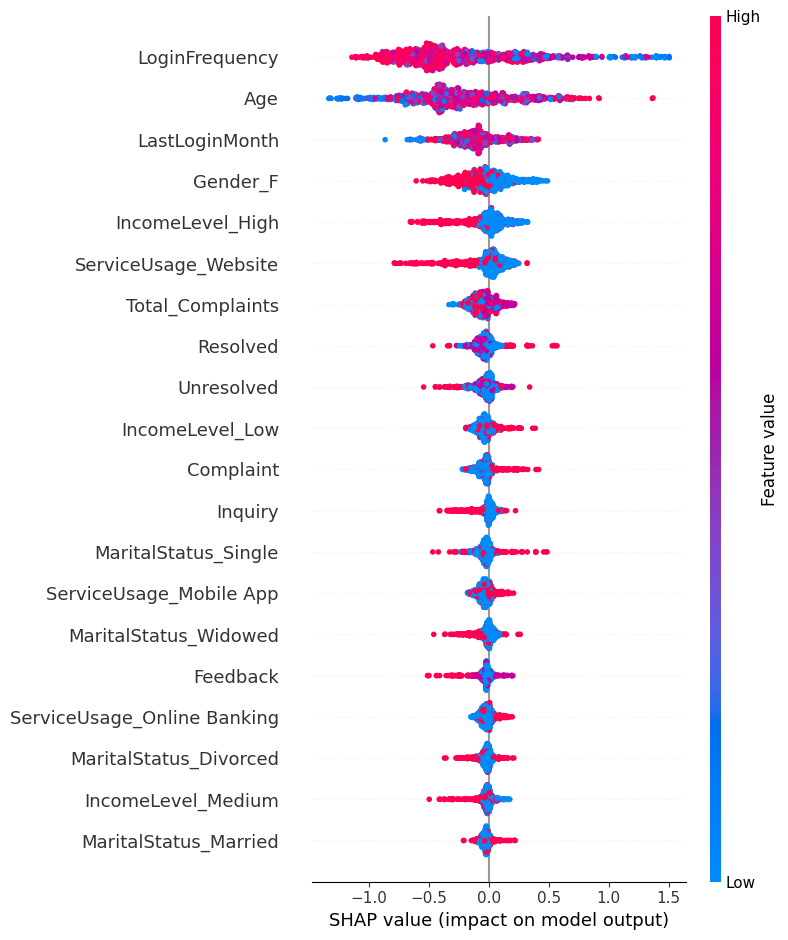

In [223]:
# Get preprocessed data (before resampling)
X_processed = xgb_best_model.named_steps['preprocess'].transform(X_test)

# Get feature names
feature_names = (
        preprocessing.named_transformers_['cat_cols'].get_feature_names_out(cat_cols).tolist() +
        num_cols
)
# Create explainer
explainer = shap.TreeExplainer(xgb_best_model.named_steps['classifier'])

# Calculate SHAP values
shap_values = explainer.shap_values(X_processed)

# For binary classification, take second class
if isinstance(shap_values, list):
    shap_values = shap_values[1]

# Create summary plot
shap.summary_plot(shap_values, X_processed, feature_names=feature_names)

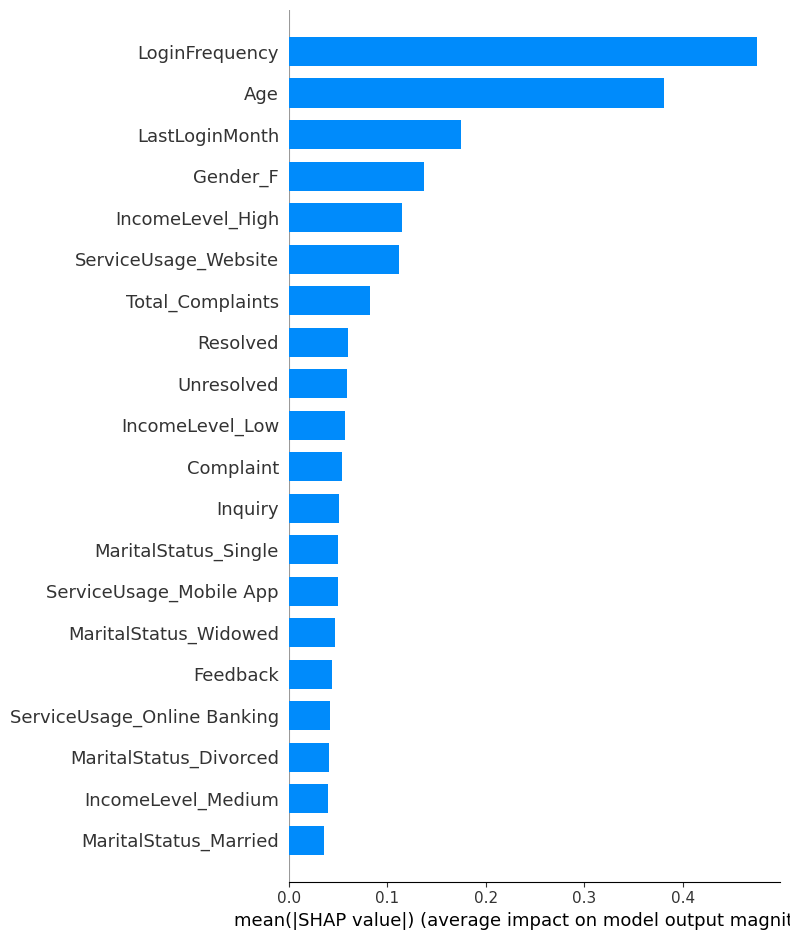

In [224]:
# Feature importance bar plot
shap.summary_plot(shap_values, X_processed, feature_names=feature_names, plot_type="bar")

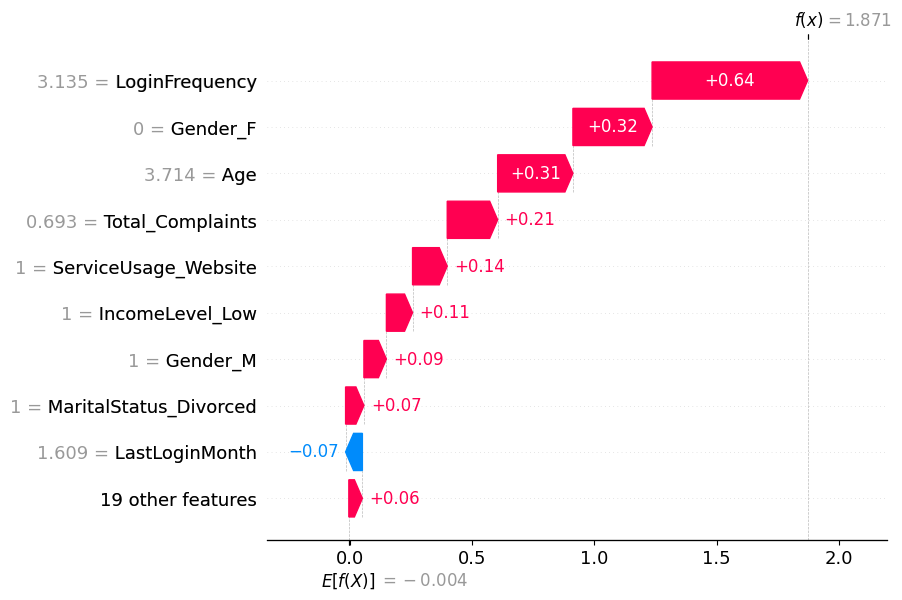

In [225]:
# Create SHAP explanation object
explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value if not isinstance(explainer.expected_value, list) else explainer.expected_value[1],
    data=X_processed,
    feature_names=feature_names
)
# Now we can create waterfall plot
shap.plots.waterfall(explanation[0])  # for first prediction

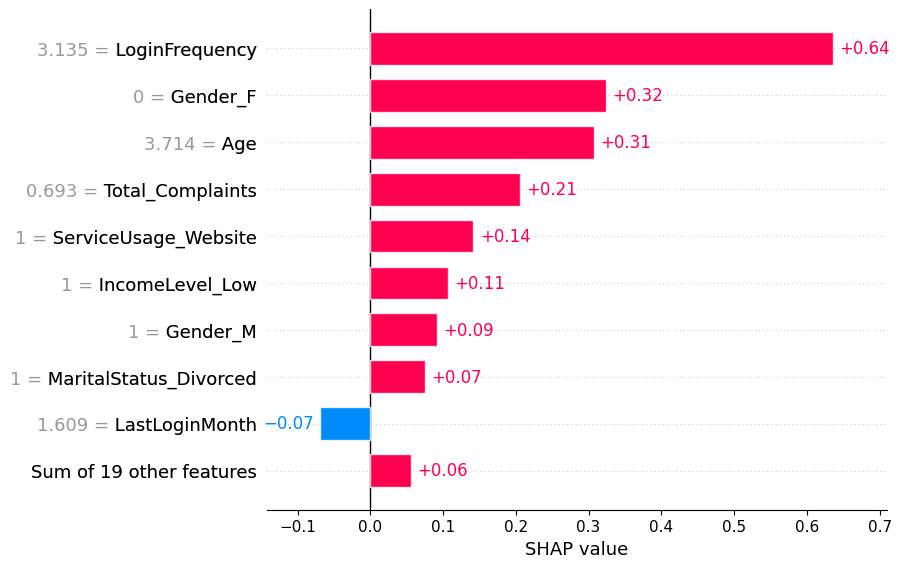

In [226]:
shap.plots.bar(explanation[0])  # for first prediction


In [227]:
shap.plots.force(explanation[0])  # for first prediction

In [228]:
# # Check if expected_value is a list/array or scalar
# if isinstance(explainer.expected_value, list) or isinstance(explainer.expected_value, np.ndarray):
#     base_value = explainer.expected_value[1]  # for binary classification
# else:
#     base_value = explainer.expected_value  # for single output
# 
# # For individual predictions
# shap.force_plot(base_value, shap_values[0], feature_names=feature_names)
# # 
# # # If you want to visualize multiple predictions:
# # shap.force_plot(base_value, shap_values[:100], feature_names=feature_names)  # first 100 predictions